# Marketing Attribution Analysis
Author: Olaoluwa J. Taiwo

# Background of the Data

The dataset contains customer interaction data across multiple digital marketing channels.

- Each record represents a user action (e.g., impression, click) with a timestamp, the associated marketing channel, and whether it led to a conversion.

- Such datasets are typically used in marketing attribution modeling to evaluate the effectiveness of campaigns and optimize channel spending.

# Goal of the Project

The primary goal is to analyze customer journeys across channels and determine which marketing channels contribute most to conversions and revenue.
This analysis will help optimize marketing budgets and improve return on investment (ROI).

# Objectives

- Explore and clean the dataset to understand user behavior patterns.

- Identify how different marketing channels (e.g., Instagram, Paid Search, Online Display) contribute to conversions.

- Compare attribution models (first-touch, last-touch, multi-touch, position-based, etc.) to understand how credit is distributed.

- Visualize customer journeys and channel performance to provide intuitive insights.

- Deliver recommendations for marketing strategy optimization.


# Expected Outcomes

- A clear understanding of which channels drive the highest conversions and revenue.

- Attribution model comparisons to guide decision-making on budget allocation.

- Visualizations of customer pathways across channels.

- Actionable insights to improve marketing efficiency and campaign performance.

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

In [81]:
df = pd.read_csv(r"C:\Users\taiwo\Downloads\attribution data.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586737 entries, 0 to 586736
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cookie            586737 non-null  object 
 1   time              586737 non-null  object 
 2   interaction       586737 non-null  object 
 3   conversion        586737 non-null  int64  
 4   conversion_value  586737 non-null  float64
 5   channel           586737 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 26.9+ MB


,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search



- The dataset contains **586,737 rows** and **6 columns**, capturing detailed user interactions across marketing channels.  
- Each row represents a unique **event** tied to a `cookie` (user/session identifier), along with a **timestamp** (`time`) and type of `interaction` (e.g., impression, click).  
- Conversion-related outcomes are tracked through:
  - `conversion` (binary flag: 0 = no conversion, 1 = conversion)  
  - `conversion_value` (numeric measure of the value generated when a conversion occurs)  
- The `channel` column categorizes the source of the interaction (e.g., Instagram, Paid Search, Online Display).  
- The dataset is memory-heavy (~26.9 MB) and primarily object/string-based, with only two numeric columns (`conversion`, `conversion_value`).  
- This structure makes it well-suited for **attribution modeling**, **channel performance analysis**, and **conversion path exploration**.  


# Data Cleaning
Clean inconsistencies and prepare the dataset for deeper analysis.

In [82]:
# 2.1 Convert timestamp to datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search


Converted the time column to datetime format so I can perform accurate time-based operations like sorting, calculating durations between events, and analyzing customer journeys chronologically. This is essential for any temporal analysis or session reconstruction.

In [83]:
# 2.2 Sort by user and time to reconstruct sessions
df = df.sort_values(by=['cookie', 'time']).reset_index(drop=True)
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search


Sorted the data by cookie (which identifies the user) and time so that each user's interactions are ordered correctly. This is a crucial step in rebuilding customer journeys and understanding how users engage with various marketing channels over time.

In [84]:
# 2.3 Check for missing values
df.isnull().sum()

cookie              0
time                0
interaction         0
conversion          0
conversion_value    0
channel             0
dtype: int64

Checked for any missing values in the dataset to ensure completeness and reliability. 

In [85]:
# 2.4 Check for mismatched conversion values
assert df[df['conversion'] == 0]['conversion_value'].sum() == 0, "Conversion value exists without conversion."

verified that no conversion value is recorded unless a conversion has actually occurred. This assertion makes sure that rows marked with conversion == 0 do not have any associated revenue, helping to maintain the integrity of the data.

# Feature Engineering

In this section, we derive new features from raw interaction data to better understand user behavior and prepare for attribution modeling. Key features include user journeys, conversion flags, journey length, and timing metrics. These features help quantify how users interact across channels and which paths lead to conversions.

In [86]:
df = df.rename(columns={'cookie': 'user_id'})
df['channel'] = df['channel'].astype(str).str.strip().str.title()

In [87]:
df = df.sort_values(['user_id', 'time']).reset_index(drop=True)
df['path_order'] = df.groupby('user_id').cumcount() + 1

In [88]:
df['time_diff'] = df.groupby('user_id')['time'].diff()
df['time_diff'] = df['time_diff'].fillna(pd.Timedelta(seconds=0))

In [89]:
df.head()

,user_id,time,interaction,conversion,conversion_value,channel,path_order,time_diff
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,1,0 days 00:00:00
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,2,14 days 06:12:56
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,3,6 days 20:36:39
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,4,4 days 15:53:05
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search,1,0 days 00:00:00


Group all interactions by user to construct their journey across marketing channels. This sequence shows the order of touchpoints and is critical for applying attribution models accurately.

In [90]:
# 3.3 Add number of steps in each journey
journeys = df.groupby('user_id')['channel'].apply(list).reset_index(name='journey')
journeys['touch_count'] = journeys['journey'].apply(len)
journeys[['user_id', 'touch_count']].head()

,user_id,touch_count
0,00000FkCnDfDDf0iC97iC703B,4
1,0000nACkD9nFkBBDECD3ki00E,6
2,0003EfE37E93D0BC03iBhBBhF,5
3,00073CFE3FoFCn70fBhB3kfon,1
4,00079hhBkDF3k3kDkiFi9EFAD,1


In [53]:
# Build journeys per user
journeys = df.groupby('user_id')['channel'].apply(list).reset_index(name='journey')

# Keep only users who converted
converted_users = df.loc[df['conversion'] == 1, 'user_id'].unique()
converters = journeys[journeys['user_id'].isin(converted_users)].copy()

# Map first conversion value per user to revenue
revenue_map = (df[df['conversion'] == 1]
               .groupby('user_id')['conversion_value']
               .first()
               .to_dict())
converters['revenue'] = converters['user_id'].map(revenue_map).fillna(0.0)

# Rename to match your loops' expectations
converters = converters.rename(columns={'journey': 'path'})[['user_id', 'path', 'revenue']]

# (Sanity check)
print(converters.columns.tolist())
display(converters.head())

['user_id', 'path', 'revenue']


,user_id,path,revenue
7,0007oEBhnoF97AoEE3BCkFnhB,[Paid Search],6.5
8,00090n9EBBEkA000C7Cik999D,[Facebook],8.0
34,000h3n9nC0hFhE3CCnkkAof7n,[Facebook],6.0
36,000hCBnCB7oi7ADAEnEBCnBEE,"[Online Video, Online Video, Online Video, Onl...",6.5
44,000kiDB3D0fCfDAohCDB3ohko,"[Facebook, Facebook]",7.5


calculated how many marketing interactions each user experienced. This feature helps analyze journey complexity, campaign saturation, and whether shorter or longer journeys lead to more conversions.

# Exploratory Data Analysis (EDA)

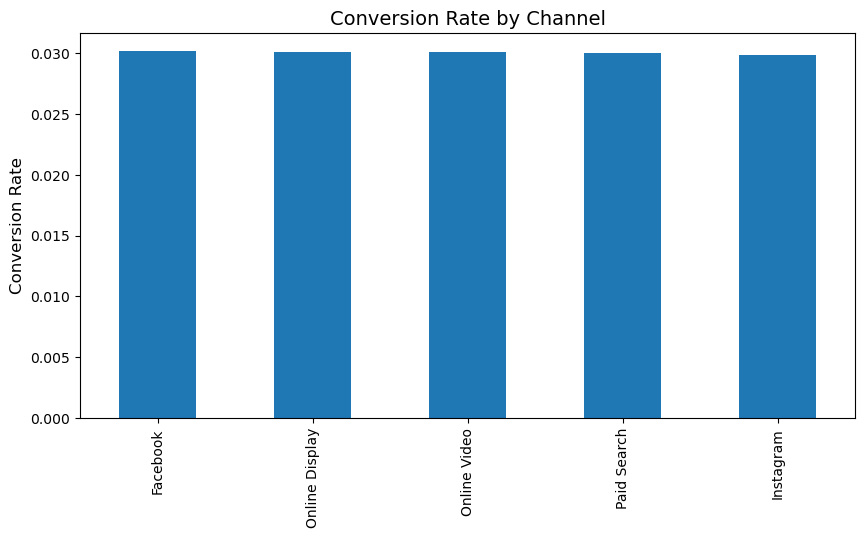

In [54]:
# 4.1 Conversion rate per channel
conv_channels = df.loc[df['conversion'] == 1, 'channel'].value_counts()
total_channels = df['channel'].value_counts()
conversion_rate = (conv_channels / total_channels).fillna(0).sort_values(ascending=False)
ax = conversion_rate.plot(kind='bar', title='Conversion Rate by Channel')
ax.set_ylabel('Conversion Rate')
plt.show()

- All marketing channels **Facebook, Online Display, Online Video, Paid Search, and Instagram** show nearly identical conversion rates, hovering around **3%**.  
- This suggests that **no single channel significantly outperforms the others** in direct conversion efficiency.  
- Since performance is uniform, strategic focus may shift from **conversion rate optimization** to **cost efficiency and reach** i.e., identifying which channels deliver conversions at the lowest cost or drive higher-value customers.  
- It also indicates that **multi-channel exposure** may play a role, reinforcing the importance of attribution modeling to capture indirect contributions.  


channel
Facebook          33143.5
Paid Search       28331.5
Online Video      21418.0
Instagram         14039.5
Online Display    13298.5
Name: conversion_value, dtype: float64


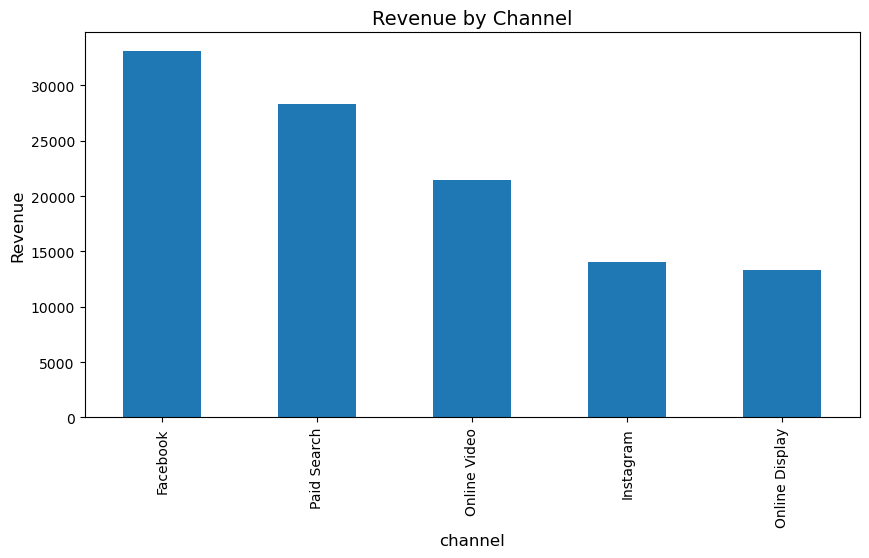

In [92]:
# Top converting channels by revenue
channel_revenue = df.groupby('channel')['conversion_value'].sum().sort_values(ascending=False)
print(channel_revenue)

ax = channel_revenue.plot(kind='bar', title='Revenue by Channel')
ax.set_ylabel('Revenue')
plt.show()

### Insight: Revenue by Channel

- **Facebook** is the clear revenue leader, generating the highest total among all channels.  
- **Paid Search** follows closely behind, making it another strong driver of revenue.  
- **Online Video** contributes a moderate amount of revenue, indicating its role as a supportive channel.  
- **Instagram** and **Online Display** generate the least revenue, suggesting lower monetization impact despite similar conversion rates seen earlier.  
- Together with the conversion rate results, this shows that while conversion efficiency is similar across channels, **Facebook and Paid Search not only convert but also drive higher-value transactions**.  

📌 **Implication:** Budget allocation should prioritise **Facebook and Paid Search**, while **Instagram and Online Display may need reevaluation** either optimizing their campaigns or repositioning them as awareness/assistance channels rather than primary revenue drivers.  


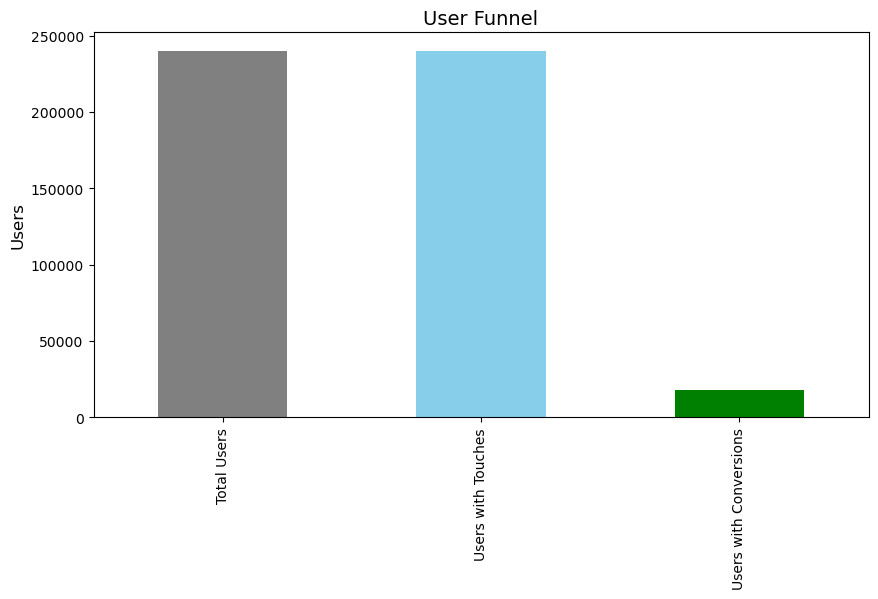

In [72]:
# 2.1 Funnel view of users
total_users = df['user_id'].nunique()
touch_users = df.loc[df['channel'].notna(),'user_id'].nunique()
converters = df.loc[df['conversion']==1,'user_id'].nunique()

funnel = pd.Series({
    'Total Users': total_users,
    'Users with Touches': touch_users,
    'Users with Conversions': converters
})

funnel.plot(kind='bar', color=['gray','skyblue','green'], title="User Funnel")
plt.ylabel("Users")
plt.show()

### Insight: User Funnel

- **Total Users vs. Active Users**: Nearly all users in the dataset had at least one touchpoint, showing strong engagement at the awareness and interaction stages.  
- **Conversion Drop-off**: Despite high engagement, only a **small fraction of users convert**, highlighting a steep drop from interaction to actual purchase/conversion.  
- This pattern is typical in digital funnels, but the large gap suggests **room for optimisation** in middle-to-lower funnel activities.  
- Possible factors:  
  - **Messaging & Offer Alignment** – users are engaging but may not find the offers compelling enough.  
  - **Journey Length & Friction** – users could be dropping off due to too many steps before conversion.  
  - **Channel Quality** – some channels may bring in traffic that engages but doesn’t convert well.  

📌 **Implication: Focus should be on conversion optimisation strategies improving targeting, simplifying the purchase process, and strengthening retargeting


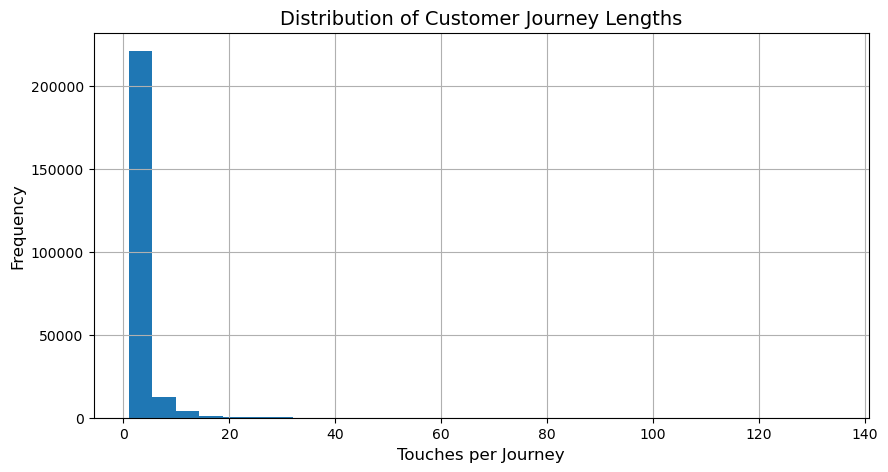

In [75]:
# 3.1 Aggregate channels per user to form path
journeys = df.groupby('user_id')['channel'].apply(list).reset_index(name='path')

# 3.2 Mark converters
converted_users = df.loc[df['conversion']==1,'user_id'].unique()
journeys['converted'] = journeys['user_id'].isin(converted_users)

# 3.3 Attach revenue (first conversion value per user)
revenue_map = (df[df['conversion']==1]
               .groupby('user_id')['conversion_value']
               .first().to_dict())
journeys['revenue'] = journeys['user_id'].map(revenue_map).fillna(0)

# 3.4 Journey length
journeys['touch_count'] = journeys['path'].str.len()

# Distribution plot
journeys['touch_count'].hist(bins=30)
plt.title("Distribution of Customer Journey Lengths")
plt.xlabel("Touches per Journey")
plt.ylabel("Frequency")
plt.show()

### Insight: Distribution of Customer Journey Lengths

- The vast majority of customer journeys consist of **fewer than 5 touchpoints**, indicating that most users either convert quickly or disengage early.  
- A long tail of journeys with **10+ touchpoints** exists, but these are relatively rare and suggest a small segment of users who require repeated exposures before making a decision.  
- Extremely long journeys (30+ touches) are outliers and may represent either **complex decision-making processes** or potential data noise (e.g., automated activity or tracking artefacts).  
- This distribution highlights that while multi-touch exposure matters, **simplicity and speed to conversion are the norm** for most users.  

**Implication:** Marketing strategies should balance:  
- **Quick-win optimisation** (ensuring early interactions are persuasive enough to drive faster conversions).  
- **Support for long journeys** (personalised nurturing for high-consideration users, without oversaturating them).  

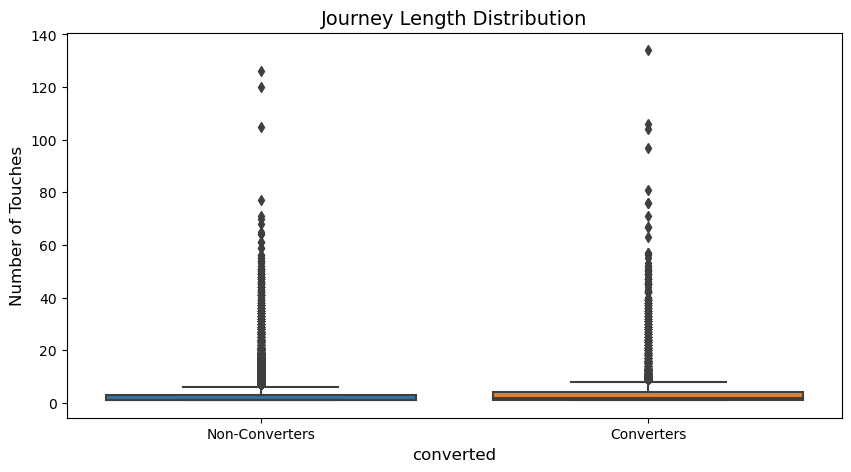

In [76]:
# 3.5 Compare journey lengths of converters vs non-converters
df['converted'] = df['user_id'].isin(converted_users)
journey_lengths = df.groupby(['user_id','converted'])['channel'].count().reset_index()

sns.boxplot(x='converted', y='channel', data=journey_lengths)
plt.xticks([0,1], ['Non-Converters','Converters'])
plt.ylabel("Number of Touches")
plt.title("Journey Length Distribution")
plt.show()

### Insight: Journey Length Distribution (Converters vs Non-Converters)

- **Typical Journeys**: Both converters and non-converters tend to have **short journeys** (median at only a few touches). This reinforces the earlier finding that most users make decisions quickly.  
- **Converters vs Non-Converters**: Converters generally show a **slightly higher median journey length**, suggesting that users who eventually purchase are willing to engage across more touchpoints before converting.  
- **Outliers**: Both groups contain extreme long journeys (100+ touches), but these are rare and could either represent **highly complex decision-making** or **tracking anomalies**.  
- **Interpretation**: A longer journey does not guarantee conversion, but having multiple interactions slightly increases the likelihood of success compared with single-touch journeys.  

**Implication:**  
- Invest in **multi-touch nurturing strategies** (retargeting, email sequences, cross-channel consistency) to support users who need more time.  
- Simultaneously, ensure **early touchpoints are strong enough** to convert quick-decision users, as they represent the majority.  

# Attribution Modeling
Implement different models to assign credit to channels.

# 1. First-Touch Attribution

In [61]:
# --- Make 'journeys' compatible with your attribution loops ---

# 1) Build a revenue map from the raw df (first conversion value per user;
#    change .first() to .sum() if you want total user revenue instead)
revenue_map = (df[df['conversion'] == 1]
               .groupby('user_id')['conversion_value']
               .first()
               .to_dict())

# 2) Keep only users who converted
journeys = journeys[journeys['user_id'].isin(revenue_map.keys())].copy()

# 3) Rename 'journey' -> 'path' and attach 'revenue'
journeys = journeys.rename(columns={'journey': 'path'})
journeys['revenue'] = journeys['user_id'].map(revenue_map).fillna(0.0)

# 4) (Optional) quick sanity check
print(journeys.columns.tolist())
display(journeys.head())

['user_id', 'path', 'revenue']


,user_id,path,revenue
7,0007oEBhnoF97AoEE3BCkFnhB,[Paid Search],6.5
8,00090n9EBBEkA000C7Cik999D,[Facebook],8.0
34,000h3n9nC0hFhE3CCnkkAof7n,[Facebook],6.0
36,000hCBnCB7oi7ADAEnEBCnBEE,"[Online Video, Online Video, Online Video, Onl...",6.5
44,000kiDB3D0fCfDAohCDB3ohko,"[Facebook, Facebook]",7.5


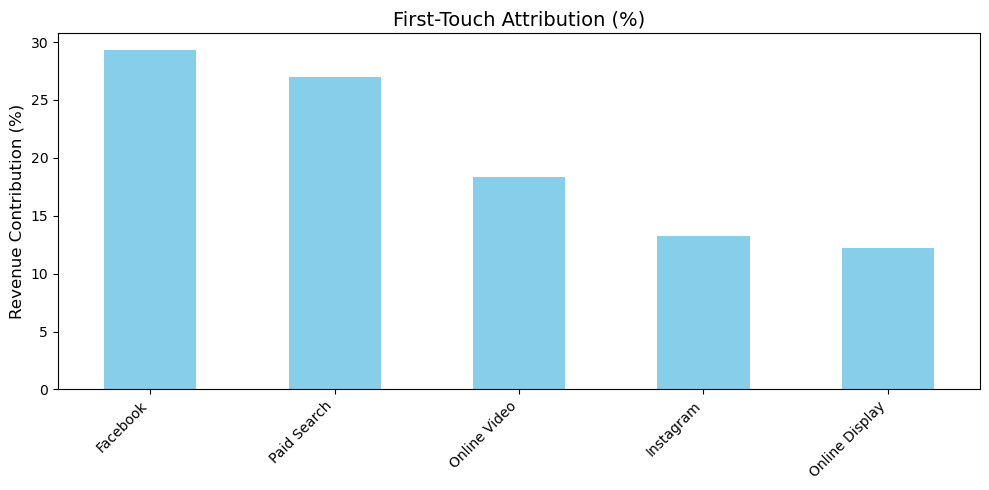

In [63]:
from collections import Counter

# First-touch
ft = Counter()
for _, r in journeys.iterrows():
    p, rev = r['path'], r['revenue']
    if p:
        ft[p[0]] += rev

ft_series = pd.Series(ft, name='First-Touch Revenue').sort_values(ascending=False)
first_touch_percent = 100 * ft_series / ft_series.sum()

# Visualize
ax = first_touch_percent.plot(kind='bar', color='skyblue', title='First-Touch Attribution (%)')
ax.set_ylabel("Revenue Contribution (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Insight: First-Touch Attribution

- **Facebook** holds the strongest role as the entry point into the funnel, driving nearly **30% of first-touch revenue**.  
- **Paid Search** follows closely at around **27%**, highlighting its importance in capturing initial intent-driven users.  
- **Online Video** contributes a meaningful share (~18%), suggesting effectiveness for awareness and early engagement.  
- **Instagram** and **Online Display** play smaller roles (13% and 12% respectively), indicating they are less common as the very first contact point.  
- This distribution suggests that **Facebook and Paid Search are the primary acquisition channels**, while others are more likely to act as supporting or reinforcing touchpoints later in the journey.  


# 2. Last-Touch Attribution (% Revenue)

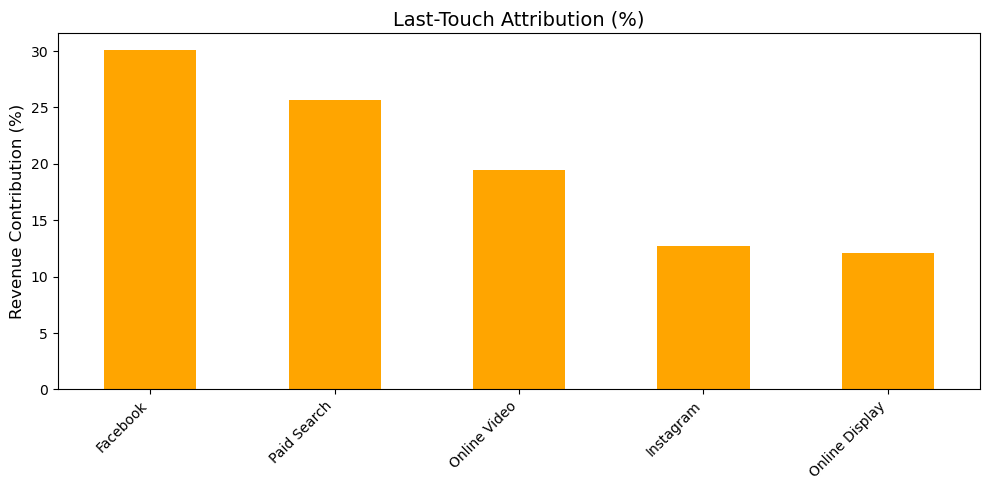

In [64]:
lt = Counter()
for _, r in journeys.iterrows():
    p, rev = r['path'], r['revenue']
    if p:
        lt[p[-1]] += rev

lt_series = pd.Series(lt, name='Last-Touch Revenue').sort_values(ascending=False)
last_touch_percent = 100 * lt_series / lt_series.sum()

# Visualize
ax = last_touch_percent.plot(kind='bar', color='orange', title='Last-Touch Attribution (%)')
ax.set_ylabel("Revenue Contribution (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Insight: Last-Touch Attribution

- **Facebook** remains the dominant channel at the conversion stage, closing around **30% of revenue**.  
- **Paid Search** is also highly effective at the bottom of the funnel, accounting for **~26%** of last-touch revenue, reflecting its role in capturing users with strong purchase intent.  
- **Online Video** contributes close to **20%**, showing that it not only raises awareness but can also support closing conversions.  
- **Instagram** (~13%) and **Online Display** (~12%) play smaller roles in sealing conversions, consistent with their limited contribution as first-touch channels.  
- The similarity between first-touch and last-touch distributions indicates that **Facebook and Paid Search dominate both acquisition and conversion**, while other channels serve more as assistive touchpoints.  



# 3. Linear Attribution (% Revenue)

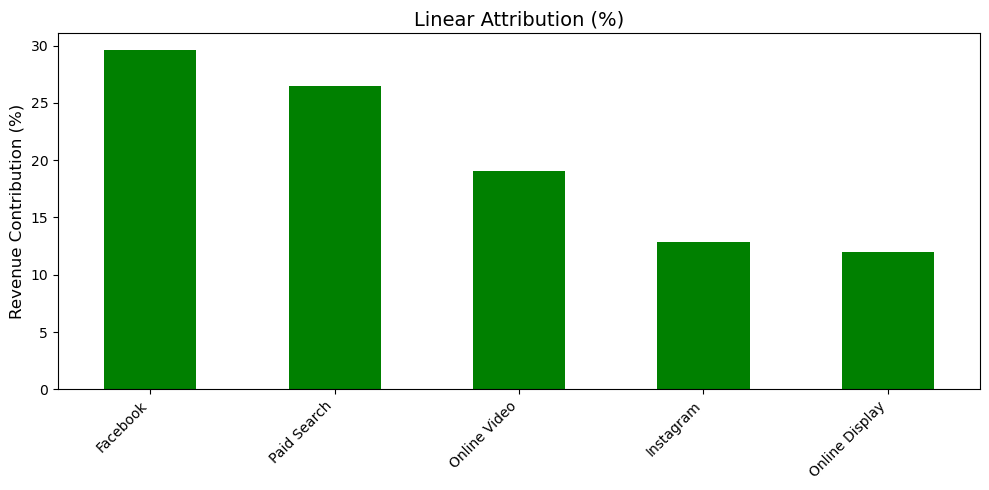

In [65]:
lin = Counter()
for _, r in journeys.iterrows():
    p, rev = r['path'], r['revenue']
    if p:
        w = rev / len(p)
        for ch in p:
            lin[ch] += w

lin_series = pd.Series(lin, name='Linear Revenue').sort_values(ascending=False)
linear_percent = 100 * lin_series / lin_series.sum()

# Visualize
ax = linear_percent.plot(kind='bar', color='green', title='Linear Attribution (%)')
ax.set_ylabel("Revenue Contribution (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Insight: Linear Attribution

- Under the linear model, **credit is distributed evenly across all touchpoints**, giving a more balanced view of channel contributions.  
- **Facebook (≈30%)** and **Paid Search (≈26%)** remain the strongest contributors, confirming their central role across the entire customer journey.  
- **Online Video (≈19%)** maintains a meaningful share, showing consistent impact both in awareness and conversion assistance.  
- **Instagram (~13%)** and **Online Display (~12%)** have smaller contributions but appear more relevant here than in first- or last-touch models, reflecting their **assistive role** across journeys.  
- Compared with first- and last-touch attribution, the linear model highlights the **multi-channel nature of conversions**, showing that even lower-ranked channels play a part in guiding users along the path to purchase.  
 

# 4. Position-Based Attribution (40-20-40) — % ROI

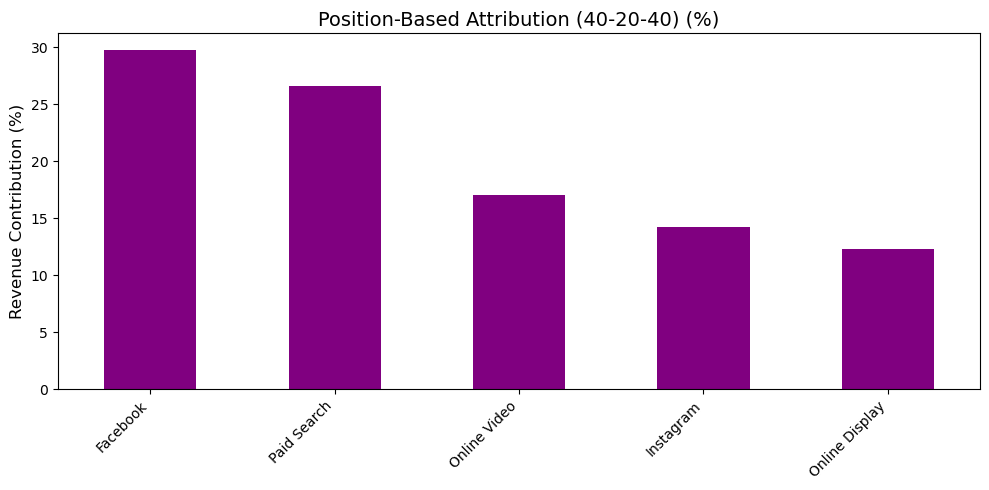

In [66]:
def pos_weights(path):
    n = len(path)
    if n == 1: return {path[0]: 1.0}
    if n == 2: return {path[0]: 0.5, path[1]: 0.5}
    w = {path[0]: 0.4, path[-1]: 0.4}
    mid = path[1:-1]
    if mid:
        mid_w = 0.2 / len(mid)
        for m in mid: w[m] = w.get(m, 0) + mid_w
    return w

pos = Counter()
for _, r in journeys.iterrows():
    p, rev = r['path'], r['revenue']
    if p:
        for ch, w in pos_weights(p).items():
            pos[ch] += rev * w

pos_series = pd.Series(pos, name='Position-Based Revenue').sort_values(ascending=False)
position_percent = 100 * pos_series / pos_series.sum()

# Visualize
ax = position_percent.plot(kind='bar', color='purple', title='Position-Based Attribution (40-20-40) (%)')
ax.set_ylabel("Revenue Contribution (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Insight: Position-Based Attribution (40-20-40)

- This model gives **40% credit to the first touch**, **40% to the last touch**, and distributes the remaining **20% across middle interactions**, reflecting both acquisition and closing influence.  
- **Facebook (~30%)** and **Paid Search (~27%)** remain the most influential channels, emphasising their strength in both initiating and closing customer journeys.  
- **Online Video (~17%)** has a smaller role compared with the linear model, indicating it is less likely to appear as the first or last interaction.  
- **Instagram (~14%)** and **Online Display (~12%)** receive moderate credit, showing their contribution mainly in supporting and reinforcing brand exposure during the journey.  
- Compared with other attribution models, position-based strikes a balance between overvaluing the first or last touch and recognising supporting channels.   


In [69]:
# We already have these from earlier sections:
# first_touch_percent, last_touch_percent, linear_percent, position_percent

channels = sorted(set(first_touch_percent.index) |
                  set(last_touch_percent.index)   |
                  set(linear_percent.index)       |
                  set(position_percent.index))

# Combine into one dataframe
roi_comparison = pd.DataFrame({
    'First-Touch %': first_touch_percent.reindex(channels).fillna(0),
    'Last-Touch %':  last_touch_percent.reindex(channels).fillna(0),
    'Linear %':      linear_percent.reindex(channels).fillna(0),
    'Position %':    position_percent.reindex(channels).fillna(0),
}).round(2)

# Display as a table
display(roi_comparison.sort_values('Position %', ascending=False))

,First-Touch %,Last-Touch %,Linear %,Position %
Facebook,29.29,30.07,29.59,29.73
Paid Search,26.97,25.70,26.48,26.63
Online Video,18.35,19.43,19.09,17.01
Instagram,13.23,12.74,12.86,14.28
Online Display,12.17,12.06,11.98,12.34


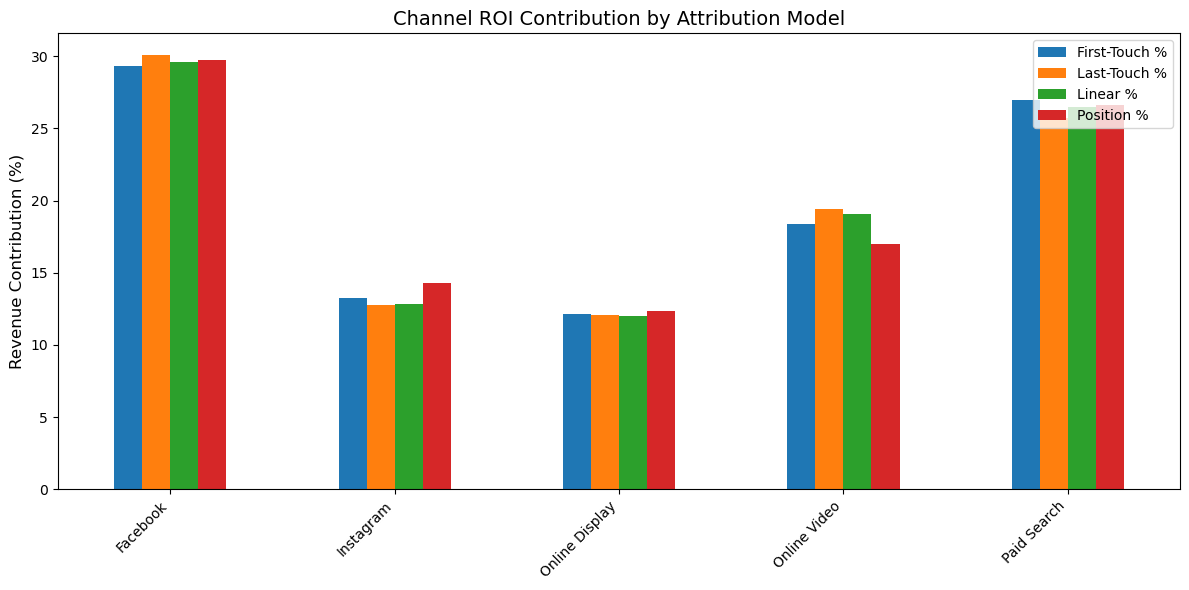

In [70]:
ax = roi_comparison.plot(kind='bar', figsize=(12,6))
ax.set_title("Channel ROI Contribution by Attribution Model")
ax.set_ylabel("Revenue Contribution (%)")
ax.legend(loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Insight: Channel ROI Contribution by Attribution Model

- **Consistency Across Models**:  
  Facebook and Paid Search dominate revenue contribution regardless of attribution model, underlining their central importance across the funnel.  

- **Facebook**: Always the top performer (~29–30%), showing strength in both acquisition and conversion.  
- **Paid Search**: Consistently second (~26–27%), reflecting its role in capturing high-intent users across touchpoints.  
- **Online Video**: Shows more variation (17–19%), gaining slightly more credit under last-touch attribution but less in position-based, suggesting its role shifts depending on funnel stage.  
- **Instagram and Online Display**: Their contributions remain modest (~12–14%) but are somewhat more valued under position-based attribution, highlighting their assistive, mid-funnel role.  

- **Key Takeaway**:  
  While absolute percentages shift slightly, the hierarchy of channel performance is stable. This indicates that **budget decisions are robust across attribution models**, though **secondary channels (Instagram, Display, Video)** should be evaluated for efficiency and supportive value rather than direct ROI.  

📌 **Implication:**  
- Keep **Facebook and Paid Search** as the core revenue drivers.  
- Use **Video, Instagram, and Display** strategically for awareness, engagement, and retargeting rather than pure conversion.  
- Consider adopting a **data-driven or hybrid attribution model** to better reflect cross-channel interactions and avoid undervaluing supportive channels.  


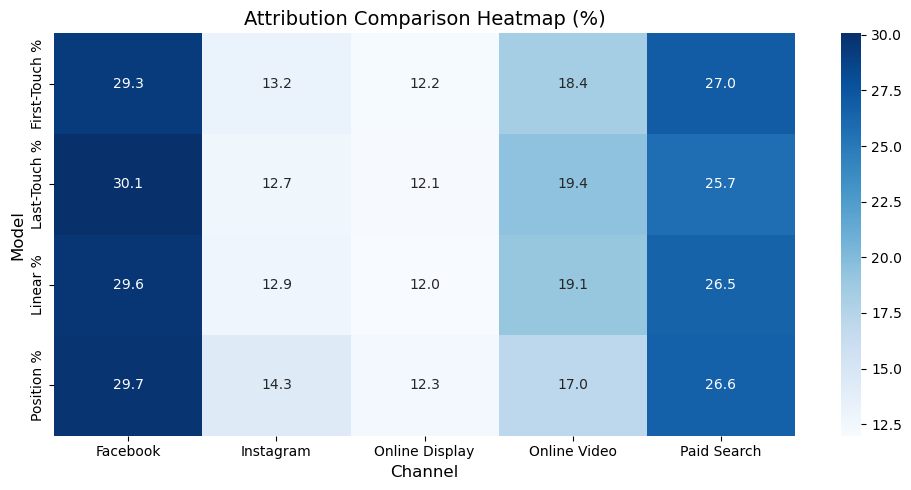

In [71]:
sns.heatmap(roi_comparison.T, annot=True, fmt=".1f", cmap="Blues")
plt.title("Attribution Comparison Heatmap (%)")
plt.ylabel("Model")
plt.xlabel("Channel")
plt.tight_layout()
plt.show()

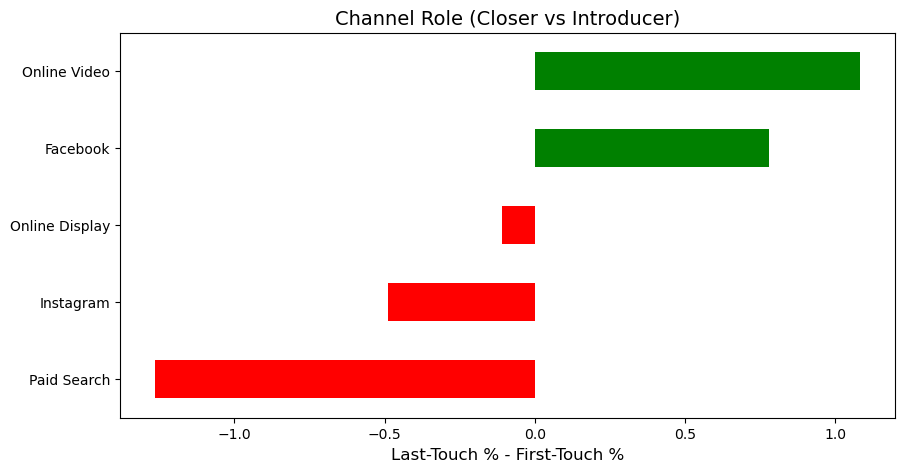

In [77]:
delta = (last_touch_percent - first_touch_percent).sort_values()
delta.plot(kind='barh', color=['red' if v<0 else 'green' for v in delta])
plt.title("Channel Role (Closer vs Introducer)")
plt.xlabel("Last-Touch % - First-Touch %")
plt.show()

### Insight: Channel Role (Closer vs Introducer)

- **Closers**: Facebook, Online Video – strong at sealing conversions.  
- **Introducers**: Paid Search, Instagram – effective for acquisition and top-funnel engagement.  
- **Supporter**: Online Display – minor role, modest influence.  

**Implication:**  
- Prioritise **Paid Search** for acquisition.  
- Use **Facebook and Video** for retargeting and conversion.  
- Position **Instagram and Display** as awareness/nurturing channels.  

# Final Recommendation

- **Double down on Facebook and Paid Search**: These are consistently the strongest revenue drivers across all attribution models. Facebook excels at both acquisition and closing, while Paid Search is highly effective as an introducer, capturing early intent. They should remain the core focus of budget allocation.  

- **Leverage Online Video as a dual-role channel**: Video plays an important part as both an introducer and a closer. It should be positioned as a flexible channel useful for awareness-building campaigns as well as remarketing strategies.  

- **Reposition Instagram and Online Display**: These channels show limited direct conversion and revenue impact, but they provide supportive, mid-funnel reinforcement. They are best suited for brand awareness, retargeting, and nurturing rather than being treated as primary performance channels.  

- **Adopt a hybrid or data-driven attribution approach**: Single-touch models risk overvaluing or undervaluing certain channels. A multi-model view ensures investment decisions reflect both acquisition and closing power as well as supportive contributions.  

📌 **Overall**: Allocate the majority of spend to **Facebook and Paid Search** for efficiency and scale, while strategically maintaining **Video, Instagram, and Display** to sustain brand presence and assist conversion journeys.  
